In [1]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st 
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from plotnine import *
import statsmodels.formula.api as sm
from utils import *
from matplotlib.lines import Line2D
from itertools import combinations

%run fmri_starter.py

warnings.filterwarnings('ignore', category=FutureWarning)

noresp_policy = "omit"


Controls:  43
Stress:  45


CA1 Control: 95% CI [0.4940231280347559, 0.5327618118315793], p = 0.0918009180091801
CA1 Stress: 95% CI [0.47263600596933936, 0.5099715099715099], p = 0.8136181361813618
CA23 Control: 95% CI [0.4982751099030169, 0.5422026294119316], p = 0.03638036380363804
CA23 Stress: 95% CI [0.5005555555567766, 0.5480115995152014], p = 0.022380223802238024
DG Control: 95% CI [0.4738192040517622, 0.5132038504131526], p = 0.7571775717757178
DG Stress: 95% CI [0.4871794871794871, 0.5241079907746575], p = 0.27691276912769125


/var/folders/z0/2d95w71s7l1dcwqglzr4flfr0000gn/T/ipykernel_40660/2306520579.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


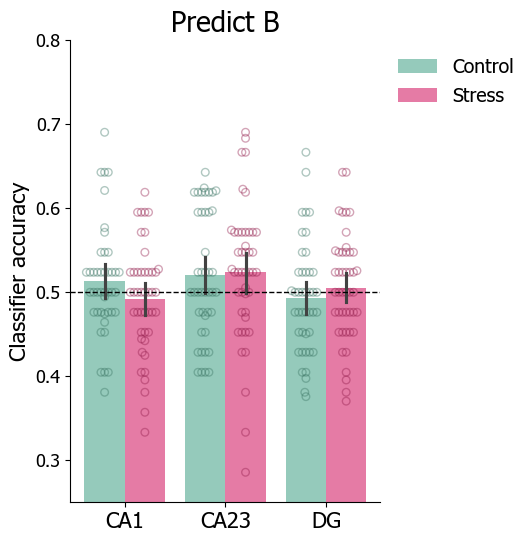

In [20]:
# load in and plot results of a single classifier type for all hippocampal subfields
plot_rois = ["CA1", "CA23", "DG"]
palette = group_colors
dark_palette = dark_group_colors
classifier_type = "B_prediction"
classifier_name = "Predict B"
groups = ["Control", "Stress"]
grp2name = {0: "Control", 1: "Stress"}

sub2grp_df = usable_subinfo[["subid", "group"]].rename(columns={"subid": "subID"})
sub2grp_df["group"] = sub2grp_df["group"].apply(lambda x: grp2name[x])

plot_df = []
for i, roi in zip(np.arange(len(plot_rois)), plot_rois):
    unified_file = f'{classifier_dir}/classifier_besthyperparams_{roi}.csv'
    unified_df = pd.read_csv(unified_file)[["subID", classifier_type]]
    
    unified_df["roi"] = [roi]*len(unified_df)
    
    plot_df.append(unified_df)

plot_df = pd.concat(plot_df)
plot_df = pd.merge(plot_df, sub2grp_df, on="subID")

fig, ax = plt.subplots(1, 1, figsize=(4, 6))
sns.barplot(ax=ax, data=plot_df, x="roi", y=classifier_type, hue="group", order=plot_rois, hue_order=groups, palette=palette, saturation=1)
sns.swarmplot(ax=ax, data=plot_df, x="roi", y=classifier_type, hue="group", order=plot_rois, hue_order=groups, palette=dark_palette, dodge=True, s=2.5, alpha=0, legend=False)

for roii in np.arange(len(plot_rois)):
    for groupi in np.arange(len(groups)):
        i = groupi + roii*len(groups)
        x_data, y_data = ax.collections[i].get_offsets().T
        ax.scatter(x_data, y_data, color="None", edgecolor=dark_palette[groupi], s=30, alpha=0.4)


# add significances
for roi in plot_rois:
    np.random.seed(0)
    for group in groups:
        vals = np.array(plot_df.loc[(plot_df["group"] == group) & (plot_df["roi"] == roi)]["B_prediction"])
        CI, pval = simple_bootstrap(vals, null=0.5, iterations=99999, onetail_hyp="above")
        print(f'{roi} {group}: 95% CI {CI}, p = {pval}')

    
ax.set_ylim(0.25, 0.8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Classifier accuracy", fontsize=16)
ax.set_xticklabels(plot_rois, fontsize=16)
ax.set_yticks(np.arange(0.3, 0.81, 0.1))
ax.set_yticklabels([f'{i:.01f}' for i in np.arange(0.3, 0.81, 0.1)], fontsize=13)
ax.set_title(classifier_name, fontsize=20)

ax.axhline(0.5, color='k', linewidth=1, linestyle='dashed')
sns.despine()


